Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [121]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [122]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [123]:
# Unzipping
import zipfile
zip_path = '/content/gdrive/MyDrive/CNN_assignment.zip'
extract_path = '/content/gdrive/MyDrive/CNN_assignment'

In [124]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [125]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
base_dir = extract_path + "/Skin cancer ISIC The International Skin Imaging Collaboration/"
data_dir_train = pathlib.Path(base_dir + "Train/")
data_dir_test = pathlib.Path(base_dir + 'Test/')

In [126]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train data: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test data: ", image_count_test)

Train data:  2239
Test data:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [127]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [128]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    seed=123,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [129]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    batch_size=batch_size,
    seed=123,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset="validation"
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [130]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

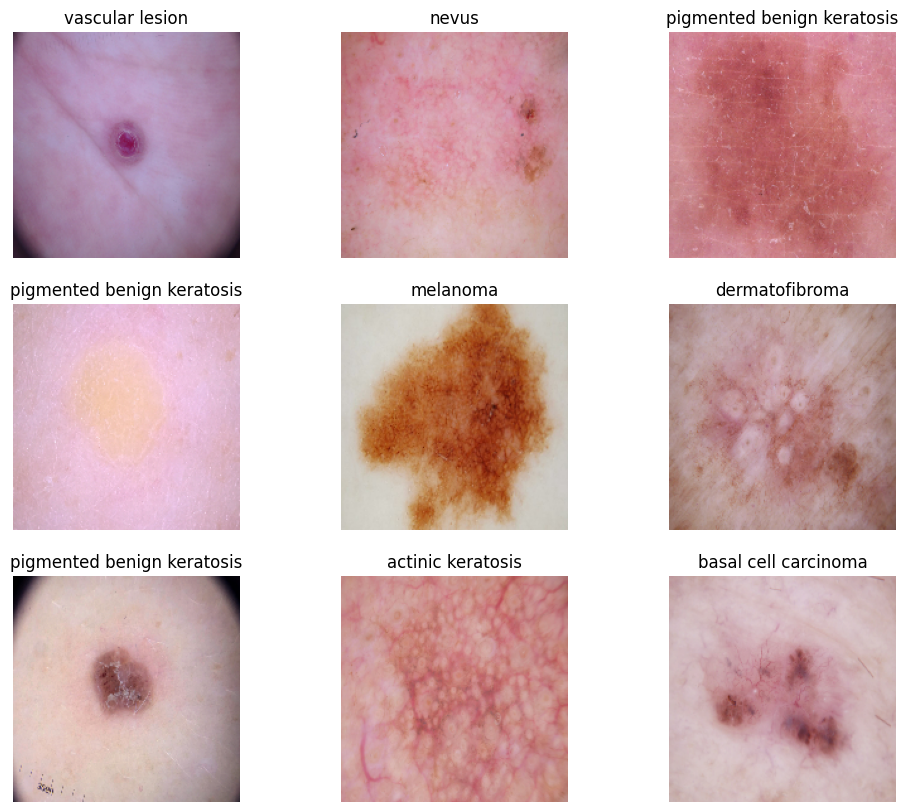

In [131]:
import matplotlib.pyplot as plt

### Plot the graph to visualize the images from each of the 9 classes
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [134]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [135]:
### Your code goes here
model = Sequential()
# rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same', input_shape = (img_height, img_width, 32)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.MaxPooling2D())
# flatten
model.add(layers.Flatten())
# 1st dense layer
model.add(layers.Dense(512, activation='relu'))
# output dense layer
model.add(layers.Dense(num_classes, activation='softmax'))

In [136]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [137]:
# View the summary of all layers
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_80 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_81 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 conv2d_83 (Conv2D)          (None, 90, 90, 32)        9248      
                                                     

### Train the model

In [138]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 81ms/step - loss: 2.0753 - accuracy: 0.1970 - val_loss: 2.3659 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 2.0288 - accuracy: 0.2009 - val_loss: 2.2726 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.9939 - accuracy: 0.2277 - val_loss: 2.3919 - val_accuracy: 0.1739
Epoch 4/20
56/56 [==============================] - 3s 56ms/step - loss: 1.9071 - accuracy: 0.2773 - val_loss: 2.2109 - val_accuracy: 0.1739
Epoch 5/20
56/56 [==============================] - 3s 57ms/step - loss: 1.8000 - accuracy: 0.3136 - val_loss: 2.5611 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.6832 - accuracy: 0.3728 - val_loss: 2.7573 - val_accuracy: 0.1304
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5781 - accuracy: 0.4258 - val_loss: 2.4328 - val_accuracy: 0.2174
Epoch 8/20
5

### Visualizing training results

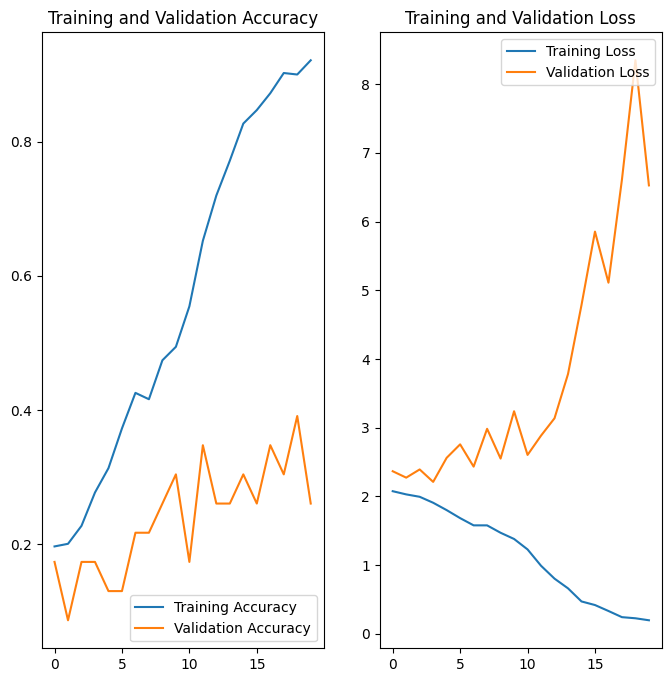

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings on the first base model


*   Cleraly we can see that the model is overfitting the train accuracy is 92% and the validation accuracy is only 30-40%
*   One of the reasons of overfitting could be lack of sufficient images as we know that CNN model require huge amount of images to learn, hence it looks like the model is memorizing the train images and therefore leading to overfitting

In [140]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# this data augmentation layer will prevent the model from memorizing the train data and hence we can handle overfiting

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

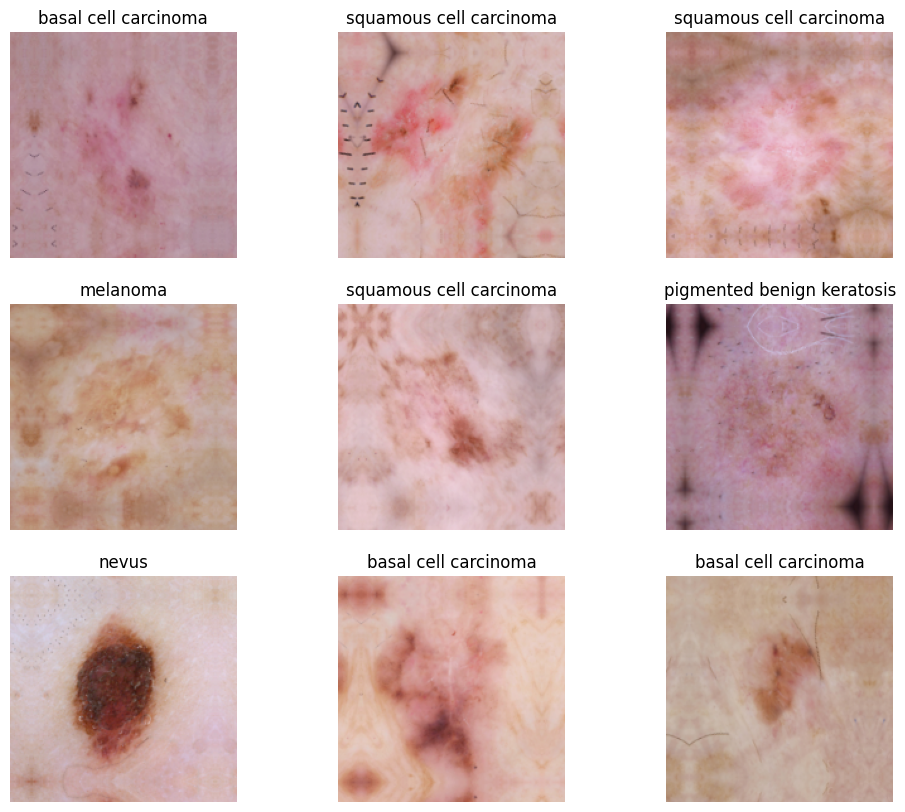

In [141]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
  for i in range(num_classes):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

### Todo:
### Create the model, compile and train the model


In [142]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential()
model.add(data_augmentation)
# rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same', input_shape = (img_height, img_width, 32)))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.MaxPooling2D())
# Dropout
model.add(layers.Dropout(0.25))
# flatten
model.add(layers.Flatten())
# 1st dense layer
model.add(layers.Dense(512, activation='relu'))
# output dense layer
model.add(layers.Dense(num_classes, activation='softmax'))

### Compiling the model

In [143]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [144]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 89ms/step - loss: 2.0568 - accuracy: 0.2031 - val_loss: 2.4140 - val_accuracy: 0.2174
Epoch 2/20
56/56 [==============================] - 5s 82ms/step - loss: 1.8767 - accuracy: 0.3086 - val_loss: 2.8213 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: 1.7055 - accuracy: 0.3571 - val_loss: 3.1237 - val_accuracy: 0.1304
Epoch 4/20
56/56 [==============================] - 5s 85ms/step - loss: 1.6669 - accuracy: 0.3906 - val_loss: 2.7407 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 5s 83ms/step - loss: 1.6335 - accuracy: 0.4062 - val_loss: 2.2381 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 5s 84ms/step - loss: 1.6152 - accuracy: 0.4074 - val_loss: 2.7476 - val_accuracy: 0.2174
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5024 - accuracy: 0.4699 - val_loss: 2.6619 - val_accuracy: 0.3043
Epoch 8/20
56

### Visualizing the results

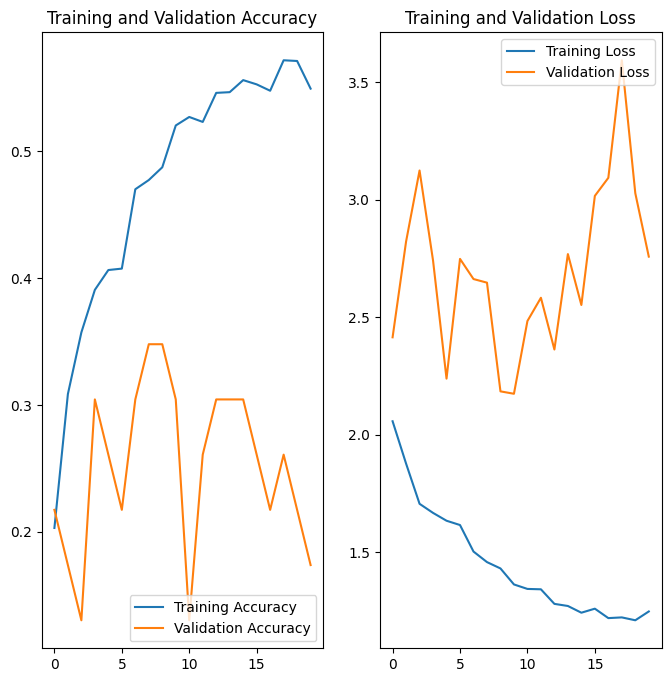

In [145]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings

*   We don't see much improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue will not be fading away due to data augmentation
*   But again, judging based on just 20 epochs won't give us proper conclusions

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [146]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_assignment/Skin ca...,vascular lesion


<BarContainer object of 9 artists>

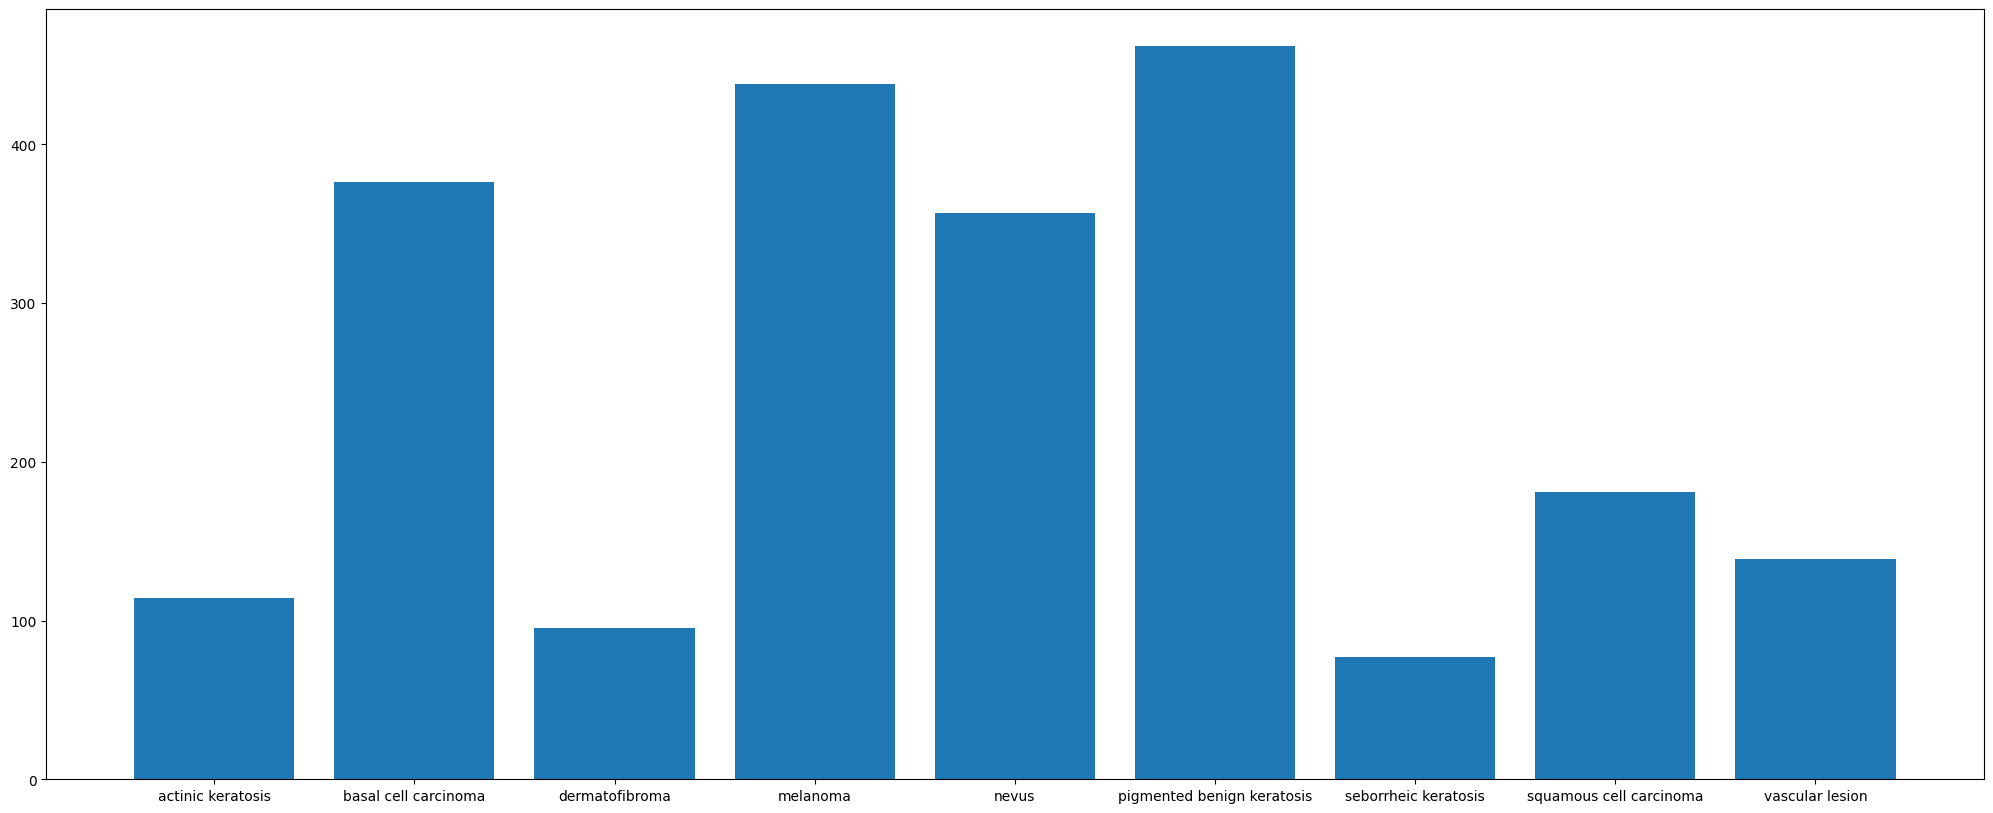

In [147]:
count=[]
for i in class_names:
  count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Findings:
#### - Seborrheic keratosis is having the lowest distribution
#### - Pigmented Benign keratosis, melanoma and basal cell carcinoma are having the highest distribution of data


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [148]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [149]:
path_to_training_dataset=base_dir+"Train/"
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789E5BC7B130>: 100%|██████████| 500/500 [00:19<00:00, 25.44 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789E5BB3C310>: 100%|██████████| 500/500 [00:22<00:00, 22.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789E5B924B50>: 100%|██████████| 500/500 [00:20<00:00, 23.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x789E5BF2B250>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x789E5BBBFFD0>: 100%|██████████| 500/500 [01:22<00:00,  6.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789F1C61E6B0>: 100%|██████████| 500/500 [00:16<00:00, 29.48 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x789F206BB610>: 100%|██████████| 500/500 [00:38<00:00, 13.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x789E5B95AFE0>: 100%|██████████| 500/500 [00:17<00:00, 28.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x789F1C61E6B0>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [150]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [151]:
import glob as glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_988e9666-e226-4772-8377-4958b38de5c8.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_973f440a-d039-43fb-94f4-3d9a486d4734.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_c7ae54d2-1903-48e8-b065-cfea622f92a9.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_fb1b5d03-bf4c-4005-98e4-8f5d34d067c2.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [152]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [153]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [154]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-154-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [155]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [157]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [159]:
data_dir_train=pathlib.Path(base_dir + "Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [160]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [161]:
## your code goes here
model = Sequential()
# rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same', input_shape = (img_height, img_width, 32)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
# Dropout
model.add(layers.Dropout(0.25))
# flatten
model.add(layers.Flatten())
# 1st dense layer
model.add(layers.Dense(512, activation='relu'))
# output dense layer
model.add(layers.Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [162]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [163]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 217ms/step - loss: 2.3575 - accuracy: 0.4126 - val_loss: 13.4581 - val_accuracy: 0.1262
Epoch 2/30
169/169 [==============================] - 40s 233ms/step - loss: 1.0594 - accuracy: 0.6180 - val_loss: 10.9752 - val_accuracy: 0.1826
Epoch 3/30
169/169 [==============================] - 39s 224ms/step - loss: 0.7511 - accuracy: 0.7372 - val_loss: 1.6428 - val_accuracy: 0.5635
Epoch 4/30
169/169 [==============================] - 42s 246ms/step - loss: 0.5215 - accuracy: 0.8125 - val_loss: 0.7737 - val_accuracy: 0.7409
Epoch 5/30
169/169 [==============================] - 45s 259ms/step - loss: 0.3848 - accuracy: 0.8633 - val_loss: 1.5368 - val_accuracy: 0.5620
Epoch 6/30
169/169 [==============================] - 42s 245ms/step - loss: 0.3483 - accuracy: 0.8780 - val_loss: 1.0859 - val_accuracy: 0.6927
Epoch 7/30
169/169 [==============================] - 38s 220ms/step - loss: 0.2600 - accuracy: 0.9034 - val_loss: 1.1324 - val_

#### **Todo:**  Visualize the model results

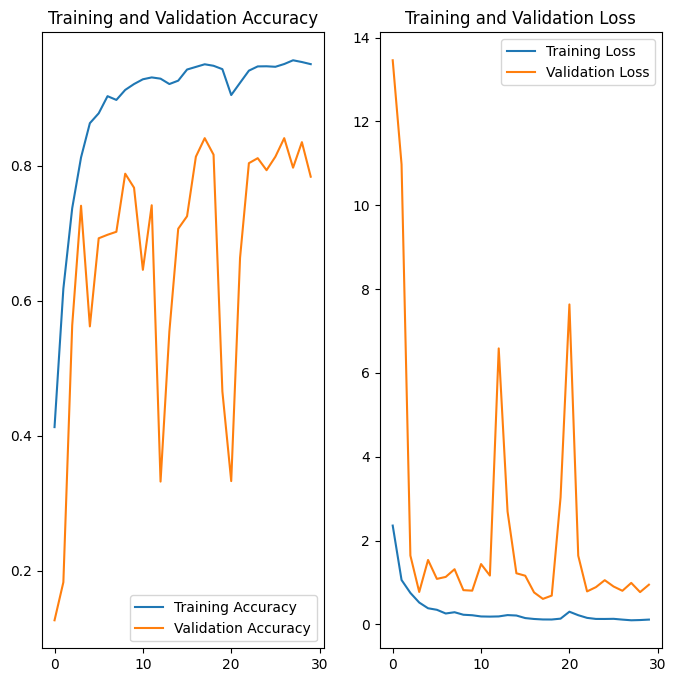

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:

* We see much improvements with respect to accuracy from the model after Building & training on the rectified class imbalance data.
* We can use this model to can accurately detect melanoma.
* We see Training accuracy gained 95% and Validation accuracy gained 78%.

